In [22]:

import pandas as pd
from zoneinfo import ZoneInfo

import mplfinance as mpf
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [4]:
import sys
from pathlib import Path

project_dir = Path().resolve().parent
sys.path.append(str(project_dir))

# import my own modules
from commonfunc.db_handler import DbHandler
from commonfunc.fetch_update import FetcherUpdater

#### 0. Getting Data and Process Date Columns

In [34]:
import os

# using absolute db path
db_file = os.path.join(project_dir, "data\crypto.db") 
db = DbHandler(db_file)
fetch_update = FetcherUpdater(db_file)

crypto = 'ETH'
crypto_lower = 'eth'

update_df = fetch_update.add_price_data(crypto=f'{crypto}', table=f'{crypto_lower}_hourly')
print(update_df)

            time                    utc_dt                    nyc_dt     high  \
1997  1738270800 2025-01-30 21:00:00+00:00 2025-01-30 16:00:00-05:00  3248.43   
1998  1738274400 2025-01-30 22:00:00+00:00 2025-01-30 17:00:00-05:00  3272.02   
1999  1738278000 2025-01-30 23:00:00+00:00 2025-01-30 18:00:00-05:00  3270.38   
2000  1738281600 2025-01-31 00:00:00+00:00 2025-01-30 19:00:00-05:00  3258.22   

          low     open    close  volumefrom     volumeto          avg  
1997  3232.01  3232.33  3244.62    26647.40  86333420.45  3239.844054  
1998  3238.57  3244.62  3261.24    14907.34  48537687.62  3255.958985  
1999  3245.37  3261.24  3247.40    17403.62  56741288.56  3260.315300  
2000  3242.12  3247.40  3244.63     4427.76  14393811.41  3250.811112  


In [6]:
# save to db if there's updated data
if not update_df.empty:
    db.save_to_db(update_df, 'eth_hourly')
    print('Updated data saved to db')
else:
    print('Data is up-to-date')

Updated data saved to db


In [7]:
# query eth price data
query = "SELECT * FROM eth_hourly order by time" # contains eth hourly data from 2018
df = db.read_from_db(query)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62018 entries, 0 to 62017
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   time        62018 non-null  int64  
 1   utc_dt      62018 non-null  object 
 2   nyc_dt      62018 non-null  object 
 3   high        62018 non-null  float64
 4   low         62018 non-null  float64
 5   open        62018 non-null  float64
 6   close       62018 non-null  float64
 7   volumefrom  62018 non-null  float64
 8   volumeto    62018 non-null  float64
 9   avg         62017 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 4.7+ MB
None


In [8]:
df['utc_dt'] = pd.to_datetime(df['utc_dt'])
df['nyc_dt'] = df['utc_dt'].apply(lambda x: x.astimezone(ZoneInfo("America/New_York")))

#### 1. Compute Technical Metrics

In [31]:
# 1. SMA: simple moving average
df['sma_24'] = df['close'].rolling(window=24).mean()  # 24-hour SMA
df['sma_72'] = df['close'].rolling(window=72).mean()  # 3-day SMA

# EMA: exponential moving average
df['ema_24'] = df['close'].ewm(span=24, adjust=False).mean()
df['ema_72'] = df['close'].ewm(span=72, adjust=False).mean()

# 2. RSI: Relative Strength Index
window = 14
delta = df['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
rs = gain / loss
df['rsi'] = 100 - (100 / (1 + rs))

# 3. MACD: moving average convergence divergence
short_ema = df['close'].ewm(span=12, adjust=False).mean()
long_ema = df['close'].ewm(span=26, adjust=False).mean()
df['macd'] = short_ema - long_ema
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

# 4. Bollinger Bands
sma = df['close'].rolling(window=20).mean()
std_dev = df['close'].rolling(window=20).std()
df['bollinger_upper'] = sma + (std_dev * 2)
df['bollinger_lower'] = sma - (std_dev * 2)

# 5. volume analysis
df['volumefrom_sma_24'] = df['volumefrom'].rolling(window=24).mean()
df['volumefrom_sma_72'] = df['volumefrom'].rolling(window=72).mean()

df.tail()

,time,utc_dt,nyc_dt,high,low,open,close,volumefrom,volumeto,avg,sma_24,sma_72,ema_24,ema_72,rsi,macd,macd_signal,bollinger_upper,bollinger_lower,volumefrom_sma_24,volumefrom_sma_72,date
62013,1738011600,2025-01-27 21:00:00+00:00,2025-01-27 16:00:00-05:00,3153.14,3141.49,3145.20,3147.19,6715.64,2.113903e+07,3147.730982,3121.961667,3252.671389,3133.003587,3219.551571,61.182719,-38.259718,-48.122798,3183.664276,3016.407724,73475.252500,33837.580556,2025-01-27 21:00:00+00:00
62014,1738015200,2025-01-27 22:00:00+00:00,2025-01-27 17:00:00-05:00,3180.54,3145.41,3158.60,3169.86,33576.91,1.062805e+08,3165.285197,3117.048750,3250.501667,3135.952100,3218.190158,64.438554,-29.894230,-44.477085,3183.893003,3016.280997,74035.582917,34043.708611,2025-01-27 22:00:00+00:00
62015,1738018800,2025-01-27 23:00:00+00:00,2025-01-27 18:00:00-05:00,3183.21,3159.25,3169.86,3181.65,33002.16,1.046145e+08,3169.929021,3114.959583,3248.722639,3139.607932,3217.189058,64.073328,-22.058886,-39.993445,3185.683136,3015.225864,71535.539167,34060.006528,2025-01-27 23:00:00+00:00
62016,1738022400,2025-01-28 00:00:00+00:00,2025-01-27 19:00:00-05:00,3203.31,3163.66,3181.65,3166.81,40011.10,1.273799e+08,3183.614012,3113.040417,3247.236389,3141.784098,3215.808810,69.437214,-16.852518,-35.365259,3187.909226,3014.124774,69113.985417,33911.997639,2025-01-28 00:00:00+00:00
62017,1738026000,2025-01-28 01:00:00+00:00,2025-01-27 20:00:00-05:00,3170.31,3159.41,3166.81,3167.59,7226.50,2.287038e+07,3164.794059,3111.942917,3245.476111,3143.848570,3214.487747,67.498170,-12.519180,-30.796044,3192.787034,3012.066966,65279.827500,33541.028333,2025-01-28 01:00:00+00:00


#### 2. Visualization

2.1 Visualization of candlestick chart with volume and MA

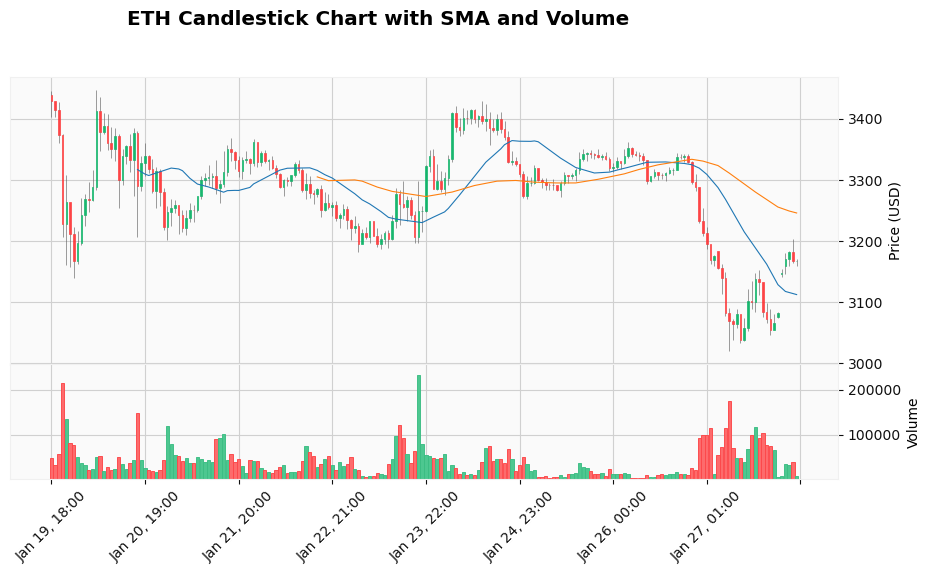

In [15]:
# Ensure required columns exist
df['date'] = df['utc_dt']  # or 'nyc_dt' for local time
ohlc_data = df[['utc_dt', 'open', 'high', 'low', 'close', 'volumefrom']].rename(columns={
    'utc_dt': 'date',  # Ensure column for the index is named 'date'
    'volumefrom': 'volume'  # Rename volume column
}).set_index('date')

crypto = 'ETH'

# Plot with SMA and Bollinger Bands
mpf.plot(
    ohlc_data[-200:],  # Last 100 hours for clarity
    type='candle',
    mav=(24, 72),  # SMA lines
    volume=True,
    style='yahoo',
    title=f'{crypto} Candlestick Chart with SMA and Volume',
    ylabel='Price (USD)',
    ylabel_lower='Volume',
    figratio=(18,9)
)


2.2 Visualization of RSI and MACD

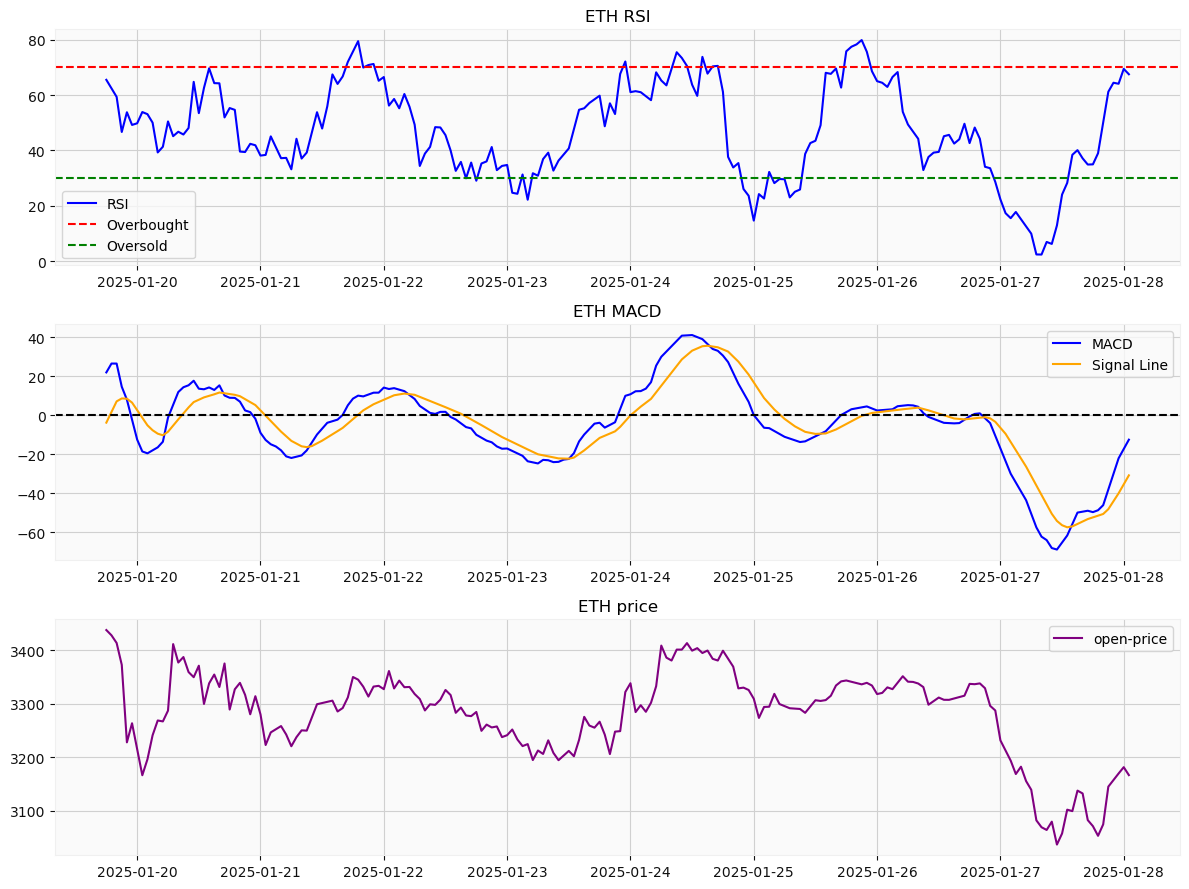

In [33]:
plt_df = df[-200:]

# Plot RSI
plt.figure(figsize=(12, 9))
plt.subplot(3, 1, 1)
plt.plot(plt_df['utc_dt'], plt_df['rsi'], label='RSI', color='blue')
plt.axhline(70, color='red', linestyle='--', label='Overbought')
plt.axhline(30, color='green', linestyle='--', label='Oversold')
plt.title(f'{crypto} RSI')
plt.legend()

# Plot MACD
plt.subplot(3, 1, 2)
plt.plot(plt_df['utc_dt'], plt_df['macd'], label='MACD', color='blue')
plt.plot(plt_df['utc_dt'], plt_df['macd_signal'], label='Signal Line', color='orange')
plt.axhline(0, color='black', linestyle='--')
plt.title(f'{crypto} MACD')
plt.legend()

# plot price
plt.subplot(3, 1, 3)
plt.plot(plt_df['utc_dt'], plt_df['open'], label='open-price', color='purple')
plt.title(f'{crypto} price')
plt.legend()

plt.tight_layout()
plt.show()


2.3 Visualization of Bollinger Bands

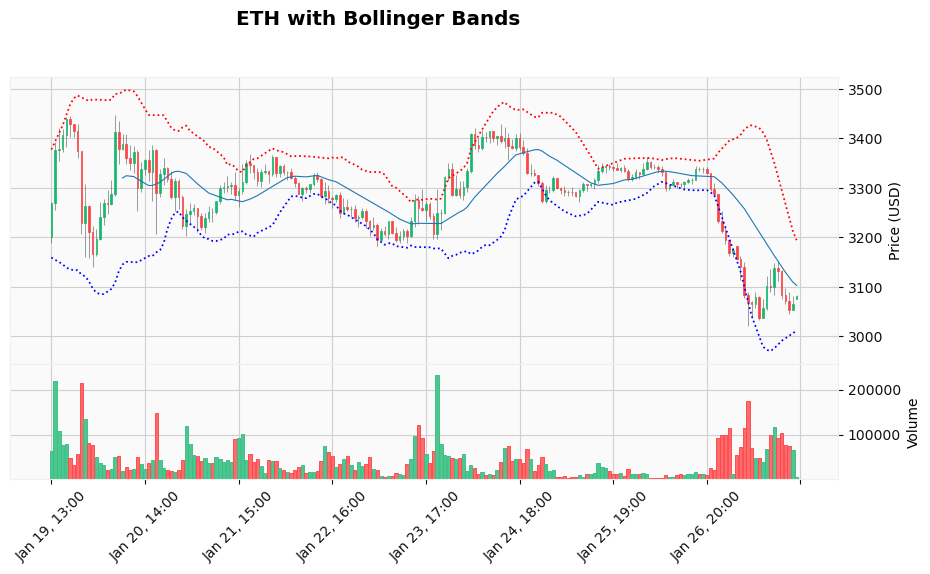

In [ ]:
df['date'] = df['utc_dt']  # or 'nyc_dt' for local time
ohlc_data = df.rename(columns={
    'volumefrom': 'volume'  # Rename volume column
}).set_index('date')

mpf.plot(
    ohlc_data[-200:],  # Last 200 rows
    type='candle',
    style='yahoo',
    mav=(20),  # Middle Band (20-period SMA)
    volume=True,
    addplot=[
        mpf.make_addplot(ohlc_data['bollinger_upper'][-200:], color='red', linestyle='dotted'),
        mpf.make_addplot(ohlc_data['bollinger_lower'][-200:], color='blue', linestyle='dotted'),
    ],
    title=f'{crypto} with Bollinger Bands',
    ylabel='Price (USD)',
    ylabel_lower='Volume',
    figratio=(18,9)
)

#### 3. Validate trading signals of each metric